In [1]:
# import packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import plotly
import plotly.graph_objs as go

# import data
fed_paper = pd.read_csv("fedPapers85.csv")
# remove 2nd column
del fed_paper["filename"]
# duplicate data to replace Names column with numbers
mapping = {'set': 1, 'test': 2}
fed_paper2 = fed_paper.replace({'Hamilton': 1, 'Madison': 2, 'Jay': 3, 'HM':4, 'dispt':5})
# create variables containing the predictive variables x and the variable to be predicted y
fed_x = fed_paper2.drop(['author'],axis=1)
fed_x_train = fed_x[12:]
fed_x_test = fed_x[0:11]
fed_y = fed_paper2['author']
fed_y_train = fed_y[12:]
fed_y_test = fed_y[0:11]
# test and train data
fed_paper_test = fed_paper2[0:11]
fed_paper_train = fed_paper2[12:]

# just values
fed_values = fed_paper2.values

In [18]:
# Describe data

# sometimes it's important to use dummy variables, e.g.,
# df = pd.get_dummies(df, columns=['column'])
# or to standardize the dat, e.g., 
# df = stats.zscore(df_tr['columns'])

# are there NAs?
fed_paper_train.isna().head() # nope
# if there were, I'd replace them with the mean value in the columns:
# train.fillna(fed_paper_train2.mean(), inplace=True)
# find out statistics of test and train data

print("***** Describe *****")
print(fed_paper2.describe())

***** Describe *****
          author          a        all       also         an        and  \
count  85.000000  85.000000  85.000000  85.000000  85.000000  85.000000   
mean    1.917647   0.293235   0.052835   0.007659   0.068388   0.384624   
std     1.407563   0.076799   0.023633   0.008409   0.029630   0.114493   
min     1.000000   0.096000   0.015000   0.000000   0.009000   0.217000   
25%     1.000000   0.240000   0.035000   0.000000   0.049000   0.319000   
50%     1.000000   0.299000   0.050000   0.007000   0.071000   0.358000   
75%     2.000000   0.349000   0.066000   0.013000   0.085000   0.413000   
max     5.000000   0.466000   0.127000   0.047000   0.179000   0.821000   

             any        are         as         at    ...            was  \
count  85.000000  85.000000  85.000000  85.000000    ...      85.000000   
mean    0.041612   0.077071   0.124200   0.044271    ...       0.025835   
std     0.022785   0.034450   0.040605   0.026210    ...       0.029051   
min

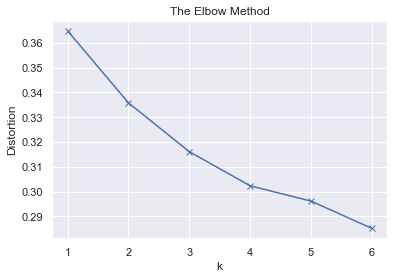

In [3]:
# elbow method
# We will start with simple k-means to get a feel for the data and should need only 4 clusters.
# Since Madison, Hamilton, Jay, or Madison & Hamilton are the authors, we want "disputed"" to be clustered into one of the four categories.
# But first, let's run the elbow test to check the potential number of clusters and then proceed with k-means clustering.
distortions = []
K = range(1,7) #arbitarily chosen; just want to get a good idea of how many potential centroids are generated.
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(fed_x)
    kmeanModel.fit(fed_x)
    distortions.append(sum(np.min(cdist(fed_x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / fed_x.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()
# the elbow plot indicates certainly 3, and perhaps 4, clusters. We'll go with 4.
kmeans = KMeans(n_clusters=4,init='k-means++',max_iter=500,n_init=25,random_state=0) 
y_kmeans = kmeans.fit_predict(fed_x)
fed_x = fed_x.values

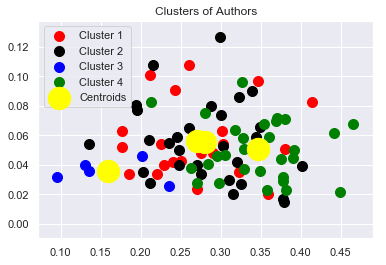

array([1, 0, 1, 0, 0, 1, 3, 0, 1, 3, 0, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3,
       3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 0, 0, 0, 2,
       2, 2, 2, 2, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [4]:
# visualize clusters
plt.scatter(fed_x[y_kmeans == 0, 0], fed_x[y_kmeans == 0,1],s=100,c='red',label='Cluster 1')
plt.scatter(fed_x[y_kmeans == 1, 0], fed_x[y_kmeans == 1,1],s=100,c='black',label='Cluster 2')
plt.scatter(fed_x[y_kmeans == 2, 0], fed_x[y_kmeans == 2,1],s=100,c='blue',label='Cluster 3')
plt.scatter(fed_x[y_kmeans == 3, 0], fed_x[y_kmeans == 3,1],s=100,c='green',label='Cluster 4')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=500,c='yellow',label='Centroids')
plt.title('Clusters of Authors')
plt.legend()
plt.show()
# this is what k-means sees, cluster-wise:
kmeans.labels_

In [7]:
# Clearly, distinct clusters cannot be viewed visually, but what can be done is to view which authors predominantly correspond to which cluster.
y_kmeansdf = pd.DataFrame(y_kmeans)
ykmeans_author = pd.concat([fed_y, y_kmeansdf], axis=1, join_axes=[fed_paper2.index])
# ykmeans_author = ykmeans_author.values
Hamilton_cluster = ykmeans_author.loc[ykmeans_author["author"]==1]
Madison_cluster = ykmeans_author.loc[ykmeans_author["author"]==2]
Jay_cluster = ykmeans_author.loc[ykmeans_author["author"]==3]
HM_cluster = ykmeans_author.loc[ykmeans_author["author"]==4]
disp_cluster = ykmeans_author.loc[ykmeans_author["author"]==4]


In [16]:
# find which author appears most often in each cluster
Hamilton_cluster.mode() # Hamilton is cluster 3

,author,0
0,1,3


In [10]:
Madison_cluster.mode() # Madison is cluster 0

,author,0
0,2,0


In [11]:
Jay_cluster.mode() # Jay is cluster 2

,author,0
0,3,2


In [14]:
HM_cluster.mode() # HM is cluster 0

,author,0
0,4,0


In [17]:
disp_cluster.mode() # disp is cluster 0

,author,0
0,4,0


In [ ]:
# Note that Madison is grouped with Hamilton and Madison.
# Thus, our clustering result suggests the disputed papers were written either by Madison or Hamilton and Madison.